<a href="https://colab.research.google.com/github/swagata87/IITKanpurPhy654/blob/main/Hbb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

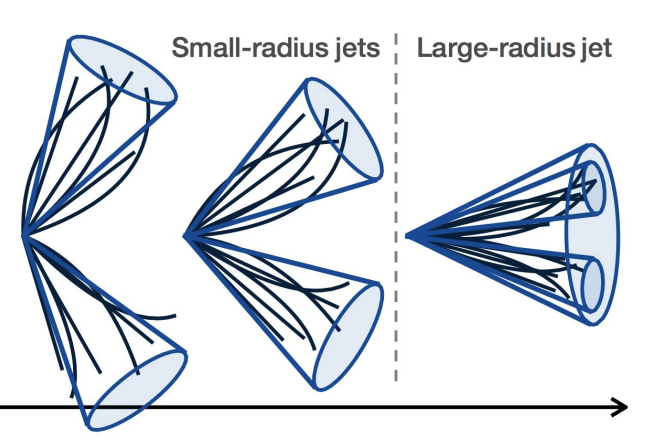

In [1]:
import keras
import numpy as np
import tables
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

2 normal jets and 1 heavy-flavor jet (say b jet)

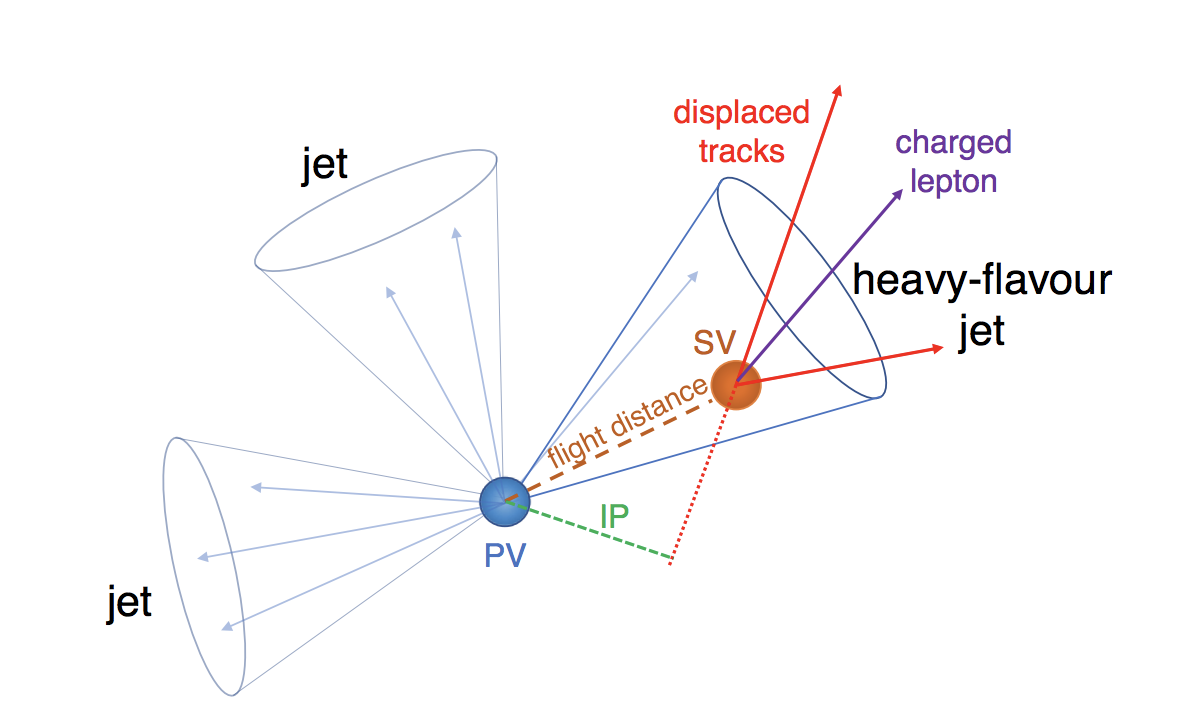

In [28]:
features = ['fj_jetNTracks', # Number of tracks in the AK8 jet
            'fj_nSV', # Number of secondary vertex in the AK8 jet
            'fj_tau_vertexDeltaR_0', # angular distance (delta_R) between the first N-subjettiness axis and SV direction
            'fj_tau_vertexMass_0', # invariant mass of all tracks from SVs associated with the first N-subjettiness axis
            'fj_tau_vertexMass_1', # invariant mass of all tracks from SVs associated with the second N-subjettiness axis
            'fj_trackSipdSig_0', # Largest 3D signed impact parameter significance of track
            'fj_trackSipdSig_0_0', # Largest track 3D signed impact parameter significance associated to the first N-subjettiness axis
            'fj_trackSipdSig_0_1', # 2nd largest track 3D signed impact parameter significance associated to the first N-subjettiness axis
            'fj_trackSipdSig_1', # 2nd largest track 3D signed impact parameter significance
            'fj_trackSipdSig_1_0', # Largest track 3D signed impact parameter significance associated to the second N-subjettiness axis
            'fj_trackSipdSig_1_1', # 2nd largest track 3D signed impact parameter significance associated to the second N-subjettiness axis
            'fj_trackSipdSig_2', # 3rd largest track 3D signed impact parameter significance
            'fj_trackSipdSig_3', # Fourth largest track 3D signed impact parameter significance
             ]

In [30]:
# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

print (labels)
nfeatures = len(features)
nlabels = len(labels)

print (nfeatures, nlabels)

['fj_isQCD*sample_isQCD', 'fj_isH*fj_isBB']
13 2


In [31]:
def get_features_labels(file_name):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    print (feature_array)
    print ('\n\n')
    print (label_array)
    return feature_array, label_array

In [5]:
# copy training file if it doesn't exist
#!xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .
!wget https://swmukher.web.cern.ch/swmukher/ntuple_merged_10.h5 .

--2024-09-10 12:31:13--  https://swmukher.web.cern.ch/swmukher/ntuple_merged_10.h5
Resolving swmukher.web.cern.ch (swmukher.web.cern.ch)... 137.138.124.182, 188.185.18.46, 188.185.5.88, ...
Connecting to swmukher.web.cern.ch (swmukher.web.cern.ch)|137.138.124.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1506845769 (1.4G)
Saving to: ‘ntuple_merged_10.h5’

ntuple_merged_10.h5 100%[===================>]   1.40G  20.7MB/s    in 64s     

2024-09-10 12:32:17 (22.6 MB/s) - ‘ntuple_merged_10.h5’ saved [1506845769/1506845769]

--2024-09-10 12:32:17--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2024-09-10 12:32:17--
Total wall clock time: 1m 5s
Downloaded: 1 files, 1.4G in 1m 4s (22.6 MB/s)


In [6]:
feature_array, label_array = get_features_labels('ntuple_merged_10.h5') #, remove_mass_pt_window=False)

[[ 1.70000000e+01  0.00000000e+00 -1.00000000e+00 ...  2.32891273e+00
   1.69894099e+00  1.56711352e+00]
 [ 1.90000000e+01  0.00000000e+00 -1.00000000e+00 ...  5.52751541e+00
   3.30181408e+00  3.11010528e+00]
 [ 6.00000000e+00  0.00000000e+00 -1.00000000e+00 ...  1.08993542e+00
   1.08993542e+00  4.29699749e-01]
 ...
 [ 8.00000000e+00  0.00000000e+00 -1.00000000e+00 ... -8.07008982e-01
   1.88087618e+00  1.72683537e+00]
 [ 1.60000000e+01  3.00000000e+00  3.43564851e-03 ...  3.69138479e-01
   3.69138479e-01  2.14498550e-01]
 [ 1.20000000e+01  1.00000000e+00  9.89833027e-02 ...  7.15288997e-01
   7.15288997e-01  4.13057894e-01]]



[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [7]:
np.shape(label_array)

(187819, 2)

In [8]:
np.shape(feature_array)

(187819, 13)

In [9]:
y=label_array[:,1]
y # Hbb=1 and QCD=0

array([0., 0., 0., ..., 0., 1., 0.])

In [10]:
np.shape(y)

(187819,)

In [11]:
feature_array[:,0] # 0th feature

array([17., 19.,  6., ...,  8., 16., 12.])

In [12]:
f_sig = feature_array[y==1]
f_bkg = feature_array[y==0]

y_sig=y[y==1]
y_bkg=y[y==0]

In [13]:
np.shape(y_sig)

(24644,)

In [14]:
np.shape(y_bkg)

(163175,)

In [15]:
np.shape(f_sig)

(24644, 13)

In [16]:
np.shape(f_bkg)

(163175, 13)

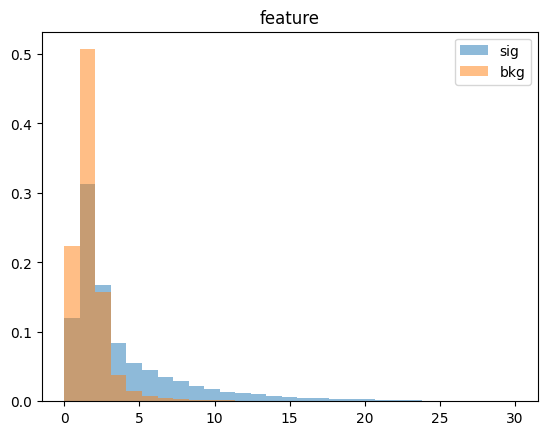

In [22]:
f0_sig=f_sig[:,11]
f0_bkg=f_bkg[:,11]
bins = np.linspace(0, 30, 30)
plt.hist(f0_sig, bins, label='sig', alpha = 0.5, density=True)
plt.hist(f0_bkg, bins, label='bkg', alpha = 0.5, density=True)
plt.legend(loc='upper right')
plt.title("feature")
plt.show()

In [23]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')
x = Dense(64, name = 'dense_1', activation='relu')(inputs)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,098 (16.01 KB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.keras', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024,
                epochs=100, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7761 - loss: 0.6317 - val_accuracy: 0.8840 - val_loss: 0.3002
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8826 - loss: 0.2976 - val_accuracy: 0.8852 - val_loss: 0.2942
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8840 - loss: 0.2925 - val_accuracy: 0.8856 - val_loss: 0.2916
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8846 - loss: 0.2900 - val_accuracy: 0.8855 - val_loss: 0.2895
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8848 - loss: 0.2883 - val_accuracy: 0.8865 - val_loss: 0.2881
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8856 - loss: 0.2869 - val_accuracy: 0.8864 - val_loss: 0.2867
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8862 - loss: 0.2855 - val_accuracy: 0.8870 - val_loss: 0.2858
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8865 - loss: 0.2844 - val_accu

In [25]:
# copy testing file if it doesn't exist
!wget https://swmukher.web.cern.ch/swmukher/ntuple_merged_0.h5

--2024-09-10 12:34:55--  https://swmukher.web.cern.ch/swmukher/ntuple_merged_0.h5
Resolving swmukher.web.cern.ch (swmukher.web.cern.ch)... 188.185.5.88, 188.185.18.46, 137.138.124.182, ...
Connecting to swmukher.web.cern.ch (swmukher.web.cern.ch)|188.185.5.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1506140388 (1.4G)
Saving to: ‘ntuple_merged_0.h5’

ntuple_merged_0.h5  100%[===================>]   1.40G  23.0MB/s    in 64s     

2024-09-10 12:36:01 (22.3 MB/s) - ‘ntuple_merged_0.h5’ saved [1506140388/1506140388]



In [26]:
# load testing file
feature_array_test, label_array_test = get_features_labels('ntuple_merged_0.h5')

[[12.          1.          0.05344623 ...  1.67628205  1.29800558
   0.64013273]
 [11.          0.         -1.         ...  2.4824264   2.2046175
   2.11899853]
 [10.          0.         -1.         ...  3.42529464  1.15944421
   0.54912364]
 ...
 [20.          2.          0.05713831 ...  7.88750315  6.73805189
   3.33155489]
 [ 8.          0.         -1.         ...  2.25520611  0.68503439
  -0.86802548]
 [13.          1.          0.0947661  ...  1.25821316  1.16976798
  -0.91398984]]



[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


5873/5873 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


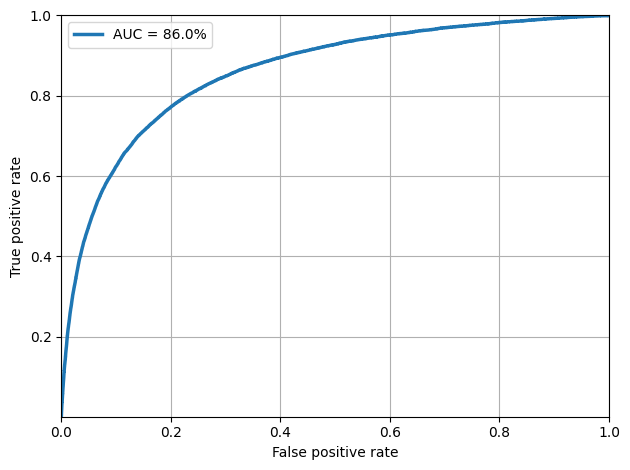

In [32]:
# reload best weights
keras_model.load_weights('keras_model_best.keras')

# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.ylabel(r'True positive rate')
plt.xlabel(r'False positive rate')
#plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')
